# Import library


In [2]:
import os, sys
import numpy as np
import pandas as pd
from scipy.io import loadmat
import glob
from scipy.signal import welch
from scipy.integrate import simps, trapz

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Anova one way
from scipy import stats

# Define constant and data preparation

In [2]:
eeg_bands = {'Delta': (0.5, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}
session1_label = [1,2,3,0,2,0,0,1,0,1,2,1,1,1,2,3,2,2,3,3,0,3,0,3]
session2_label = [2,1,3,0,0,2,0,2,3,3,2,3,2,0,1,1,2,1,0,3,0,1,3,1]
session3_label = [1,2,2,1,3,3,3,1,1,2,1,0,2,3,3,0,2,3,0,0,2,0,1,0]

unused_keys = ["__header__", "__version__","__globals__"]

# Prepare for analytic
electrodes_list = [
    'FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3',
    'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1',
    'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ',
    'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2',
    'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4',
    'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1',
    'O1', 'OZ', 'O2', 'CB2'
] # Orders from dataset
session1 = np.array(session1_label)
session2 = np.array(session2_label)
session3 = np.array(session3_label)


directories = ["../data/eeg_raw_data/{}/".format(i+1) for i in range(3)]

# Function to calculate band power for an EEG data
- Based on descrition of Dataset, we have sample rate = 1000Hz, window time = 4
- We apply a raw signal processing pipeline:
  - Convert the raw signal into welch peridogram
  - Calculate the accumulation area over a specific band by simpson approximation

In [3]:
def calculate_band_power(eeg_data, eeg_bands, sr=1000, win=4):
    # Calculate frequency resolution
    n = win * sr
    freqs, psd = welch(eeg_data, sr, nperseg=n)
    freq_resolution = freqs[1] - freqs[0]
    # Calculate power band
    result = dict()
    result["total_power"] = simps(psd, dx=freq_resolution)
    for key, value in eeg_bands.items():
        low, high = value[0], value[1]

        idx_delta = np.logical_and(freqs >= low, freqs <= high)
        result[key] = simps(psd[idx_delta], dx=freq_resolution)
    
    return result

# In the next step, we will prepare data for analysis
- Due to the complexity of this dataset, I broke the data into smaller parts by two steps:
  - I collect the whole power band into a single list (trial_result)
  - Use the trial_result to create five power bands for 62 electrodes signal into different array. Named:
delta_data, theta_data, alpha_data, beta_data and gamma_data. Each array will have shape (3,15,24,62), which means 3 session x 15 person x 24 trials x 62 electrodes.
- Each value of the array is the power value

In [4]:
# Perform 62 calculates of a subject for a trials
def create_array_power_band(subject_sample):
        
    trial_result = list()
    num_trials = len(session1_label)
    for i in range(num_trials):
        trial_key = "eeg"+str(i)
        for j in subject_sample.keys():
            if trial_key == j.split("_")[1]:
                eeg_no = subject_sample[j].shape[0]
                total_eeg_result = list()
                for k in range(eeg_no):
                    data = subject_sample[j][k]
                    result = calculate_band_power(data, eeg_bands)
                    total_eeg_result.append(result)
                # trial_result[j] = total_eeg_result
                trial_result.append(total_eeg_result)
    return trial_result


In [5]:
delta_data = np.zeros(shape=(3,15,24,62))
theta_data = np.zeros(shape=(3,15,24,62))
alpha_data = np.zeros(shape=(3,15,24,62))
beta_data = np.zeros(shape=(3,15,24,62))
gamma_data = np.zeros(shape=(3,15,24,62))

for dir_index, directory in enumerate(directories):
    if dir_index == 1:
        session_label = session1_label
    elif dir_index == 2:
        session_label = session2_label
    else:
        session_label = session3_label
    eeg_raw_file = glob.glob(directory+"*.mat")
    for file_idx, file in enumerate(eeg_raw_file):
        sample = loadmat(file)
        trial_result = create_array_power_band(sample) #[0 24 trials from 0 to 24
        for trial_idx, i in enumerate(trial_result): # Single trial
            for index, electrod in enumerate(i): # 62 electrodes
                delta = electrod["Delta"]
                theta = electrod["Theta"]
                alpha = electrod["Alpha"]
                beta = electrod["Beta"]
                gamma = electrod["Gamma"]
                
                delta_data[dir_index][file_idx][trial_idx][index] = delta
                theta_data[dir_index][file_idx][trial_idx][index] = theta
                alpha_data[dir_index][file_idx][trial_idx][index] = alpha
                beta_data[dir_index][file_idx][trial_idx][index] = beta
                gamma_data[dir_index][file_idx][trial_idx][index] = gamma            


# Prepare data for analytics
- Concat the whole experiment data into a single list for each band and emotion. This data will be used for ANOVA analysis
- I need correlation cofficients between each electrode. There are 62 electrodes which create a (62,62) correlation matrix. Because maybe there is a relationship between each electrodes signal when emotion change
- The function cof_analytic has two inputs:
  - Band: the band name that we will calculate
  - Emotion: appropriate emotion class
- After this step, I have:
  - Correlation cofficients matrix, use for correlation analysis. E.g: neutral_delta_cof_value is the correlations cof of 62 electrodes for delta band and neutral emotion.
  - Data sample for each band and emotion. Each sample will have size = (62,15*18) = (62,270). This data will be used for hypothesis testing

In [6]:
def cof_analytic(band='delta', emotion=1):
    emotion1 = np.where(session1 == emotion)[0].tolist()
    emotion2 = np.where(session2 == emotion)[0].tolist()
    emotion3 = np.where(session3 == emotion)[0].tolist()
    
    cof_matrix = np.zeros(shape=(62,62))

    # Get data
    if band == 'delta':
        array_data = delta_data
    if band == 'theta':
        array_data = theta_data
    if band == 'alpha':
        array_data = alpha_data
    if band == 'beta':
        array_data = beta_data
    if band == 'gamma':
        array_data = gamma_data
        
    total_list = list() # Total data of a frequency band
    for electrode_idx in range(0,62):
        electrode = list()
        for i in range(0,15):
            for j in range(0,24):
                if j in emotion1:
                    electrode.append(array_data[0][i][j][electrode_idx])
                if j in emotion2:
                    electrode.append(array_data[1][i][j][electrode_idx])
                if j in emotion3:
                    electrode.append(array_data[2][i][j][electrode_idx])
        total_list.append(electrode)
    final_list = np.array(total_list)

    # Calculate correlation cofficients
    for i in range(0,62):
        for j in range(0,62):
            a = final_list[i][:]
            b = final_list[j][:]
            cof = np.corrcoef(a,b)
                    
            cof_matrix[i][j] = cof[0][1]


    # Remove diagonal value because cof at diagonal = 1
    temp_mat = cof_matrix
    np.fill_diagonal(temp_mat, -np.inf)

    # Top 10 values of cof
    num_top_values = 10
    flat_indices = np.argpartition(temp_mat.flatten(), -num_top_values)[-num_top_values:]
    
    row_indices, col_indices = np.unravel_index(flat_indices, temp_mat.shape)
    top_indices = list(zip(row_indices, col_indices))
    
    top_values = cof_matrix[row_indices, col_indices]

    # Create list of cofficients for 1891 pairs
    cof_value = list()
    for i in range(cof_matrix.shape[0]):
        for j in range(i + 1, cof_matrix.shape[1]):
            cof_value.append(cof_matrix[i, j])

    return cof_value, top_indices, total_list # Return correlation cof, top 10 highest correlation cof and full data list of 62 nodes

In [7]:
# Collect result for plotting
# band + emotion = 0 neutral
neutral_delta_cof_value, neutral_delta_top_idx, total_neutral_delta = cof_analytic(band='delta',emotion=0)
neutral_theta_cof_value, neutral_theta_top_idx, total_neutral_theta = cof_analytic(band='theta',emotion=0)
neutral_alpha_cof_value, neutral_alpha_top_idx, total_neutral_alpha = cof_analytic(band='alpha',emotion=0)
neutral_beta_cof_value, neutral_beta_top_idx, total_neutral_beta = cof_analytic(band='beta',emotion=0)
neutral_gamma_cof_value, neutral_gamma_top_idx, total_neutral_gamma = cof_analytic(band='gamma',emotion=0)

# Band + emotion = 1 sad
sad_delta_cof_value, sad_delta_top_idx, total_sad_delta = cof_analytic(band='delta',emotion=1)
sad_theta_cof_value, sad_theta_top_idx, total_sad_theta = cof_analytic(band='theta',emotion=1)
sad_alpha_cof_value, sad_alpha_top_idx, total_sad_alpha = cof_analytic(band='alpha',emotion=1)
sad_beta_cof_value, sad_beta_top_idx, total_sad_beta = cof_analytic(band='beta',emotion=1)
sad_gamma_cof_value, sad_gamma_top_idx, total_sad_gamma = cof_analytic(band='gamma',emotion=1)

# Band + emotion = 2 fear
fear_delta_cof_value, fear_delta_top_idx, total_fear_delta = cof_analytic(band='delta',emotion=2)
fear_theta_cof_value, fear_theta_top_idx, total_fear_theta = cof_analytic(band='theta',emotion=2)
fear_alpha_cof_value, fear_alpha_top_idx, total_fear_alpha = cof_analytic(band='alpha',emotion=2)
fear_beta_cof_value, fear_beta_top_idx, total_fear_beta = cof_analytic(band='beta',emotion=2)
fear_gamma_cof_value, fear_gamma_top_idx, total_fear_gamma = cof_analytic(band='gamma',emotion=2)

# Band + emotion = 3 happy
happy_delta_cof_value, happy_delta_top_idx, total_happy_delta = cof_analytic(band='delta',emotion=3)
happy_theta_cof_value, happy_theta_top_idx, total_happy_theta = cof_analytic(band='theta',emotion=3)
happy_alpha_cof_value, happy_alpha_top_idx, total_happy_alpha = cof_analytic(band='alpha',emotion=3)
happy_beta_cof_value, happy_beta_top_idx, total_happy_beta = cof_analytic(band='beta',emotion=3)
happy_gamma_cof_value, happy_gamma_top_idx, total_happy_gamma = cof_analytic(band='gamma',emotion=3)

In [8]:
# Flatten all list
# total_neutral_delta = [item for sublist in total_neutral_delta for item in sublist]
# total_neutral_theta = [item for sublist in total_neutral_theta for item in sublist]
# total_neutral_alpha = [item for sublist in total_neutral_alpha for item in sublist]
# total_neutral_beta = [item for sublist in total_neutral_beta for item in sublist]
# total_neutral_gamma = [item for sublist in total_neutral_gamma for item in sublist]

# total_sad_delta = [item for sublist in total_sad_delta for item in sublist]
# total_sad_theta = [item for sublist in total_sad_theta for item in sublist]
# total_sad_alpha = [item for sublist in total_sad_alpha for item in sublist]
# total_sad_beta = [item for sublist in total_sad_beta for item in sublist]
# total_sad_gamma = [item for sublist in total_sad_gamma for item in sublist]

# total_fear_delta = [item for sublist in total_fear_delta for item in sublist]
# total_fear_theta = [item for sublist in total_fear_theta for item in sublist]
# total_fear_alpha = [item for sublist in total_fear_alpha for item in sublist]
# total_fear_beta = [item for sublist in total_fear_beta for item in sublist]
# total_fear_gamma = [item for sublist in total_fear_gamma for item in sublist]

# total_happy_delta = [item for sublist in total_happy_delta for item in sublist]
# total_happy_theta = [item for sublist in total_happy_theta for item in sublist]
# total_happy_alpha = [item for sublist in total_happy_alpha for item in sublist]
# total_happy_beta = [item for sublist in total_happy_beta for item in sublist]
# total_happy_gamma = [item for sublist in total_happy_gamma for item in sublist]

# Statistical analysis
The null hypothesis for oneway ANOVA is defined as below:

- Null hypothesis: There is no different between the mean (x1,x2,....xn) of the populations

Because our problem is Emotion Classification based on EEG signal. The null hypothesis is intepreted into below:

- Null hypothesis: There is no different between each electrode action on emotion


# ANOVA for gamma power band

In [9]:
f_statistic, p_value = stats.f_oneway(*total_neutral_gamma)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_sad_gamma)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_happy_gamma)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_fear_gamma)
print(f_statistic, p_value)

1.1850261017569672 0.15337694008640107
2.424112119190864 4.02708119871393e-09
1.9432534839470375 1.5305477157827447e-05
2.3539977530464062 1.4487386032285476e-08


# Intepret the value:
- p_value of hypothesis test for neutral = 0.15 > 0.05: mean that we cannot not reject null hypothesis testing for neutral emotion. That means that there is no different between gamma signal of 62 electrode when emotion is neutral
- The others 3 p_value is smaller that 0.05, mean that we will reject null hypothesis. In short, we can use gamma as a feature to distinguish between three emotions (sad,happy,fear)

# ANOVA for theta power band

In [10]:
f_statistic, p_value = stats.f_oneway(*total_neutral_theta)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_sad_theta)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_fear_theta)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_happy_theta)
print(f_statistic, p_value)

0.006570595190349843 0.9999999999999999
1.9849786170723414 7.912705857862804e-06
1.0850418519405038 0.30301828115754487
1.145983311641592 0.20387960385322376


# Intepret the value:
- p_value of hypothesis test for neutral, fear, happy = 0.15 > 0.05: mean that we cannot not reject null hypothesis testing for neutral emotion. That means that there is no different between gamma signal of 62 electrodes when emotion is (neutral,fear,happy)
- The p_value of sad os smaller that 0.05, mean that we will reject null hypothesis. Mean that when emotion is sad, there is a different in theta power band between 62 electrodes

In [11]:
# Similar testing for other power bands:
f_statistic, p_value = stats.f_oneway(*total_neutral_alpha)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_sad_alpha)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_fear_alpha)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_happy_alpha)
print(f_statistic, p_value)

f_statistic, p_value = stats.f_oneway(*total_neutral_beta)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_sad_beta)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_fear_beta)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_happy_beta)
print(f_statistic, p_value)

f_statistic, p_value = stats.f_oneway(*total_neutral_delta)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_sad_delta)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_fear_delta)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(*total_happy_delta)
print(f_statistic, p_value)

0.5863875668479149 0.9958709745532941
1.8566658592720786 5.7826516778774956e-05
1.156977043025095 0.18862697196475486
1.6462940982442578 0.0011371509784922874
1.9294402650698326 1.899036528238841e-05
2.698026203902902 2.200958561227595e-11
1.9816535438213825 8.343515035381605e-06
2.057521464734326 2.4437719844177226e-06
0.06423775424152131 0.9999999999999999
1.0418817852473217 0.3868332767040308
1.0000916108806917 0.4758474649657664
0.9967393540352858 0.4832109639174408


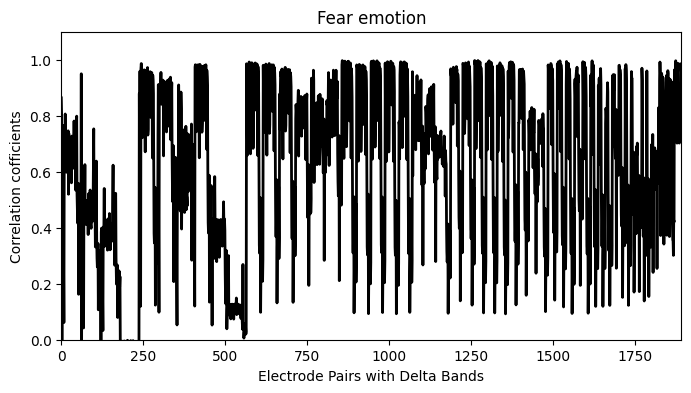

<Figure size 640x480 with 0 Axes>

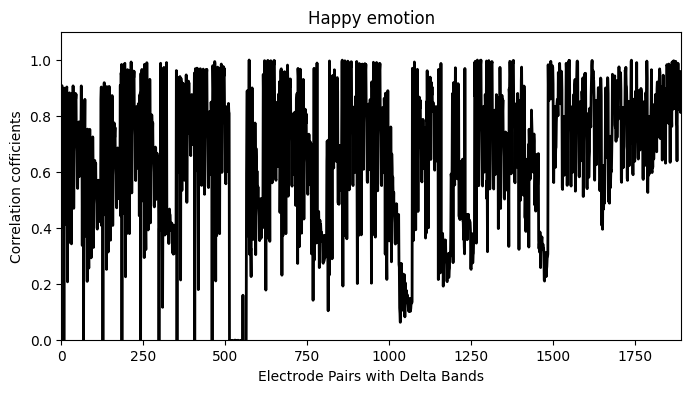

<Figure size 640x480 with 0 Axes>

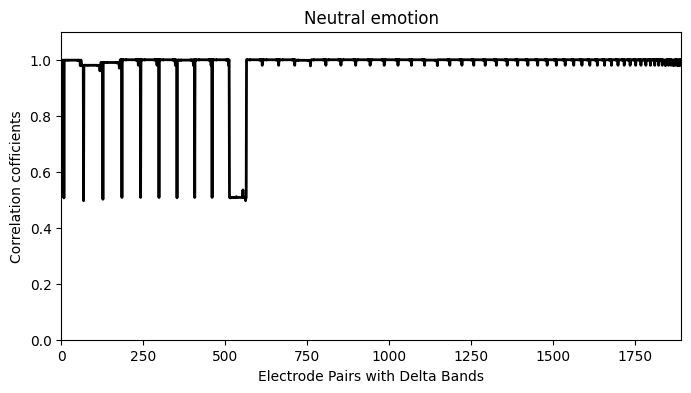

<Figure size 640x480 with 0 Axes>

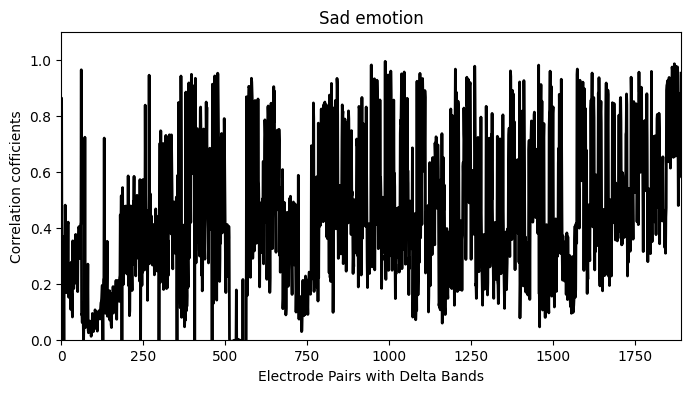

<Figure size 640x480 with 0 Axes>

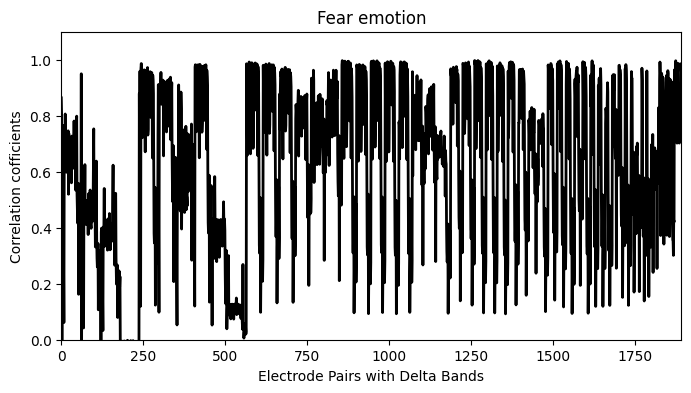

<Figure size 640x480 with 0 Axes>

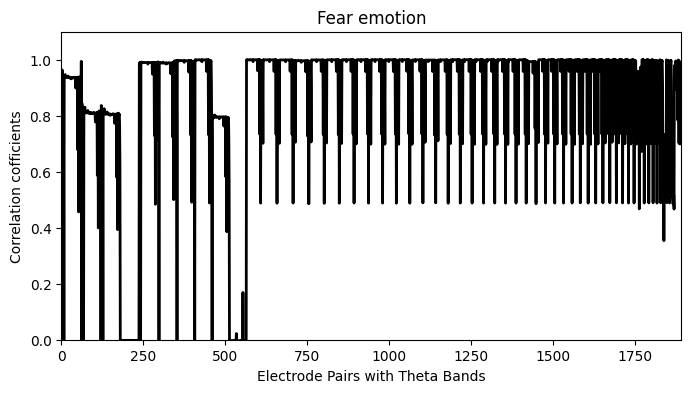

<Figure size 640x480 with 0 Axes>

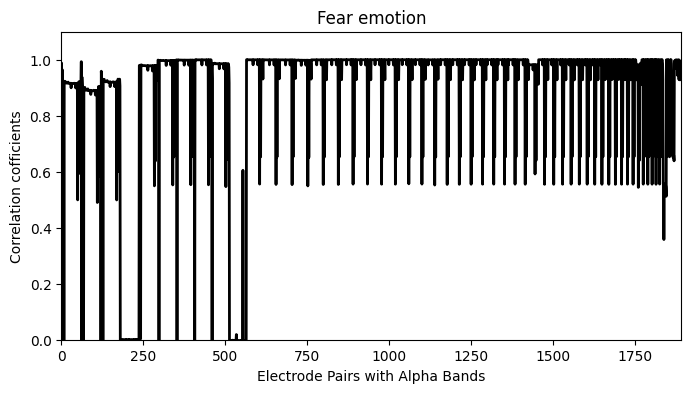

<Figure size 640x480 with 0 Axes>

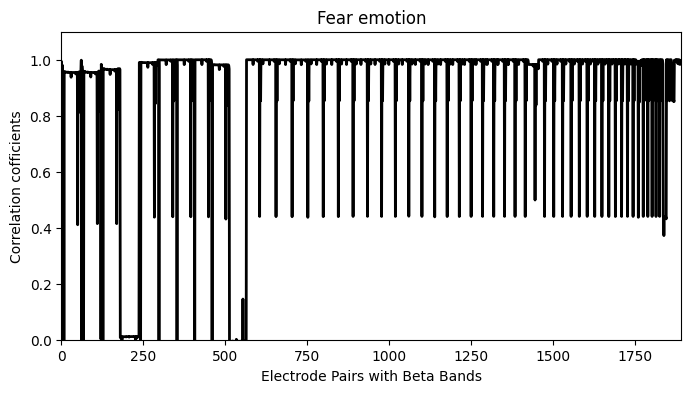

<Figure size 640x480 with 0 Axes>

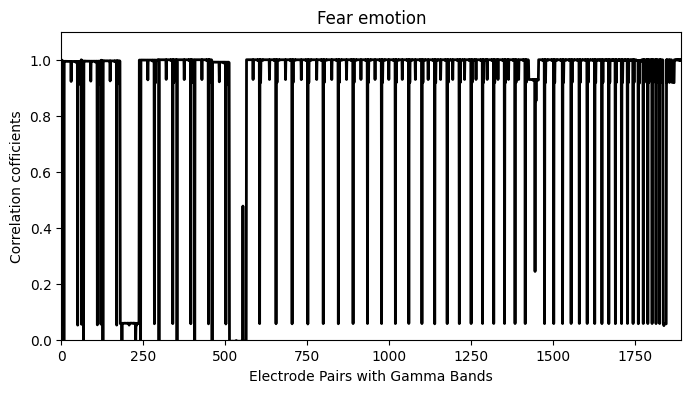

<Figure size 640x480 with 0 Axes>

In [9]:
x_axis = list()
for i in range(0,1891):
    x_axis.append(i)

# Plotting band over emotion

plt.figure(figsize=(8, 4))
plt.plot(x_axis,fear_delta_cof_value, color='k', lw=2)
plt.xlabel('Electrode Pairs with Delta Bands')
plt.ylabel('Correlation cofficients')
plt.ylim([0, 1 * 1.1])
plt.title("Fear emotion")
plt.xlim([0, 1891])
plt.show()
sns.despine()


plt.figure(figsize=(8, 4))
plt.plot(x_axis,happy_delta_cof_value, color='k', lw=2)
plt.xlabel('Electrode Pairs with Delta Bands')
plt.ylabel('Correlation cofficients')
plt.ylim([0, 1 * 1.1])
plt.title("Happy emotion")
plt.xlim([0, 1891])
plt.show()
sns.despine()

plt.figure(figsize=(8, 4))
plt.plot(x_axis, neutral_delta_cof_value, color='k', lw=2)
plt.xlabel('Electrode Pairs with Delta Bands')
plt.ylabel('Correlation cofficients')
plt.ylim([0, 1 * 1.1])
plt.title("Neutral emotion")
plt.xlim([0, 1891])
plt.show()
sns.despine()

plt.figure(figsize=(8, 4))
plt.plot(x_axis, sad_delta_cof_value, color='k', lw=2)
plt.xlabel('Electrode Pairs with Delta Bands')
plt.ylabel('Correlation cofficients')
plt.ylim([0, 1 * 1.1])
plt.title("Sad emotion")
plt.xlim([0, 1891])
plt.show()
sns.despine()


plt.figure(figsize=(8, 4))
plt.plot(x_axis,fear_delta_cof_value, color='k', lw=2)
plt.xlabel('Electrode Pairs with Delta Bands')
plt.ylabel('Correlation cofficients')
plt.ylim([0, 1 * 1.1])
plt.title("Fear emotion")
plt.xlim([0, 1891])
plt.show()
sns.despine()

plt.figure(figsize=(8, 4))
plt.plot(x_axis,fear_theta_cof_value, color='k', lw=2)
plt.xlabel('Electrode Pairs with Theta Bands')
plt.ylabel('Correlation cofficients')
plt.ylim([0, 1 * 1.1])
plt.figure(
plt.title("Fear emotion")
plt.xlim([0, 1891])
plt.show()
sns.despine()

plt.figure(figsize=(8, 4))
plt.plot(x_axis,fear_alpha_cof_value, color='k', lw=2)
plt.xlabel('Electrode Pairs with Alpha Bands')
plt.ylabel('Correlation cofficients')
plt.ylim([0, 1 * 1.1])
plt.title("Fear emotion")
plt.xlim([0, 1891])
plt.show()
sns.despine()

# Plotting emotion over band
plt.figure(figsize=(8, 4))
plt.plot(x_axis,fear_beta_cof_value, color='k', lw=2)
plt.xlabel('Electrode Pairs with Beta Bands')
plt.ylabel('Correlation cofficients')
plt.ylim([0, 1 * 1.1])
plt.title("Fear emotion")
plt.xlim([0, 1891])
plt.show()
sns.despine()

plt.figure(figsize=(8, 4))
plt.plot(x_axis,fear_gamma_cof_value, color='k', lw=2)
plt.xlabel('Electrode Pairs with Gamma Bands')
plt.ylabel('Correlation cofficients')
plt.ylim([0, 1 * 1.1])
plt.title("Fear emotion")
plt.xlim([0, 1891])
plt.show()sad_gamma_top_idx
sns.despine()

# Pick a highest correlation cofficients for gamma band


In [91]:
sad_gamma_top_idx
for i in sad_gamma_top_idx:
    print(electrodes_list[i[0]],electrodes_list[i[1]])

P2 P1
P1 P2
CPZ CZ
FCZ FC2
CZ CPZ
CP4 C4
CP3 C3
C3 CP3
FC2 FCZ
C4 CP4
